In [1]:
import pandas as pd

df = pd.read_csv("market_features_master.csv", index_col=0, parse_dates=True)
df.head()


,SP500_price,NASDAQ_price,ARKK_price,IVV_price,QQQ_price,SPY_price,VTI_price,SP500_ret,NASDAQ_ret,ARKK_ret,IVV_ret,QQQ_ret,SPY_ret,VTI_ret
Date,,,,,,,,,,,,,,
2015-01-05,2020.579956,4652.569824,17.763418,168.691437,93.514389,168.003738,86.824471,-0.018278,-0.015706,-0.024095,-0.017560,-0.014669,-0.018060,-0.017182
2015-01-06,2002.609985,4592.740234,17.696638,167.171509,92.260529,166.421356,85.973709,-0.008893,-0.012859,-0.003759,-0.009010,-0.013408,-0.009419,-0.009799
2015-01-07,2025.900024,4650.470215,17.777857,169.239655,93.449860,168.495193,86.999603,0.011630,0.012570,0.004589,0.012371,0.012891,0.012461,0.011933
2015-01-08,2062.139893,4736.189941,18.174925,172.262985,95.238457,171.485168,88.534264,0.017888,0.018432,0.022335,0.017864,0.019140,0.017745,0.017640
2015-01-09,2044.810059,4704.069824,18.021513,170.809509,94.611534,170.110916,87.800285,-0.008404,-0.006782,-0.008441,-0.008438,-0.006583,-0.008014,-0.008290


In [2]:
df.columns

Index(['SP500_price', 'NASDAQ_price', 'ARKK_price', 'IVV_price', 'QQQ_price',
       'SPY_price', 'VTI_price', 'SP500_ret', 'NASDAQ_ret', 'ARKK_ret',
       'IVV_ret', 'QQQ_ret', 'SPY_ret', 'VTI_ret'],
      dtype='object')

### Benchmark GARCH Returns

In [4]:
#pip install arch 
#!pip install prophet
#!pip install tensorflow-macos #for windows, it's without the "-macos"
#!pip install tensorflow-metal


In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.18.0
[]


In [9]:
import pandas as pd
import numpy as np

# ================================
# FIX: Disable GPU BEFORE TF loads
# ================================
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow running on CPU only.")

# Now safe to import Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from prophet import Prophet



TensorFlow running on CPU only.


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [10]:
# =========================================================
# LOAD DATA
# =========================================================

df = pd.read_csv("market_features_master.csv", index_col=0, parse_dates=True)

# Return series to benchmark
return_cols = [
    "SP500_ret", "NASDAQ_ret",
    "SPY_ret", "QQQ_ret", "VTI_ret", "IVV_ret", "ARKK_ret"
]

results = []


# =========================================================
# HELPER: LSTM SEQUENCE BUILDER
# =========================================================

def create_lstm_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)


# =========================================================
# BENCHMARK LOOP FOR EACH ASSET
# =========================================================

for col in return_cols:
    print(f"\n==============================")
    print(f"Benchmarking for {col}")
    print(f"==============================\n")

    y = df[col].dropna()

    # Train-test split
    split = int(len(y) * 0.8)
    y_train = y[:split]
    y_test = y[split:]

    # -----------------------------------------------------
    # 1. RANDOM WALK BASELINE
    # -----------------------------------------------------
    rw_pred = y_train.shift(1).iloc[-len(y_test):]
    rw_mse = mean_squared_error(y_test, rw_pred)
    rw_mae = mean_absolute_error(y_test, rw_pred)

   # -----------------------------------------------------
    # 2. GARCH (FIXED VERSION)
    # -----------------------------------------------------
    try:
        garch = arch_model(y_train, vol="Garch", p=1, q=1, dist="normal")
        garch_fit = garch.fit(disp="off")

        forecast = garch_fit.forecast(horizon=len(y_test))

        # FIX: extract correct forecast vector
        garch_pred = forecast.mean.iloc[-1].values

        garch_mse = mean_squared_error(y_test, garch_pred)
        garch_mae = mean_absolute_error(y_test, garch_pred)

    except Exception as e:
        print(f"❌ GARCH failed for {col}: {e}")
        garch_mse, garch_mae = np.nan, np.nan

    # -----------------------------------------------------
    # 3. PROPHET
    # -----------------------------------------------------
    try:
        prophet_df = y.reset_index()
        prophet_df.columns = ["ds", "y"]

        train_df = prophet_df.iloc[:split]
        test_df = prophet_df.iloc[split:]

        m = Prophet()
        m.fit(train_df)

        future = m.make_future_dataframe(periods=len(test_df))
        forecast = m.predict(future)

        prophet_pred = forecast["yhat"].iloc[-len(test_df):].values

        prophet_mse = mean_squared_error(test_df["y"], prophet_pred)
        prophet_mae = mean_absolute_error(test_df["y"], prophet_pred)

    except Exception as e:
        print(f"❌ Prophet failed for {col}: {e}")
        prophet_mse, prophet_mae = np.nan, np.nan

    # -----------------------------------------------------
    # 4. LSTM (CPU ONLY — FIXED)
    # -----------------------------------------------------
    try:
        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

        y_train_scaled = y_scaled[:split]
        y_test_scaled = y_scaled[split:]

        X_train, y_train_lstm = create_lstm_sequences(y_train_scaled)
        X_test, y_test_lstm = create_lstm_sequences(y_test_scaled)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train_lstm, epochs=10, batch_size=16, verbose=0)

        lstm_pred_scaled = model.predict(X_test)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

        true_test = y.iloc[-len(lstm_pred):]

        lstm_mse = mean_squared_error(true_test, lstm_pred)
        lstm_mae = mean_absolute_error(true_test, lstm_pred)

    except Exception as e:
        print(f"❌ LSTM failed for {col}: {e}")
        lstm_mse, lstm_mae = np.nan, np.nan

    # -----------------------------------------------------
    # SAVE RESULTS
    # -----------------------------------------------------
    results.append({
        "Asset": col,
        "RW_MSE": rw_mse, "RW_MAE": rw_mae,
        "GARCH_MSE": garch_mse, "GARCH_MAE": garch_mae,
        "Prophet_MSE": prophet_mse, "Prophet_MAE": prophet_mae,
        "LSTM_MSE": lstm_mse, "LSTM_MAE": lstm_mae
    })


# =========================================================
# FINAL RESULTS TABLE
# =========================================================

results_df = pd.DataFrame(results)
print("\n===== FINAL BENCHMARK RESULTS =====\n")
print(results_df)

results_df.to_csv("benchmark_results.csv", index=False)
print("\nSaved results to benchmark_results.csv")



Benchmarking for SP500_ret



/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:49:45 - cmdstanpy - INFO - Chain [1] start processing
03:49:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:49:50 - cmdstanpy - INFO - Chain [1] start processing



Benchmarking for NASDAQ_ret



03:49:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Benchmarking for SPY_ret



/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001344. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:49:53 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001769. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:49:57 - cmdstanpy - INFO - Chain [1] start processing



Benchmarking for QQQ_ret



03:49:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:50:00 - cmdstanpy - INFO - Chain [1] start processing



Benchmarking for VTI_ret



03:50:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:50:04 - cmdstanpy - INFO - Chain [1] start processing



Benchmarking for IVV_ret



03:50:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003353. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
03:50:07 - cmdstanpy - INFO - Chain [1] start processing



Benchmarking for ARKK_ret



03:50:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/tsproj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

===== FINAL BENCHMARK RESULTS =====

        Asset    RW_MSE    RW_MAE  GARCH_MSE  GARCH_MAE  Prophet_MSE  \
0   SP500_ret  0.000443  0.013771   0.000083   0.006821     0.000109   
1  NASDAQ_ret  0.000532  0.016265   0.000151   0.009106     0.000169   
2     SPY_ret  0.000421  0.013537   0.000082   0.006783     0.000106   
3     QQQ_ret  0.000540  0.016417   0.000164   0.009448     0.000179   
4     VTI_ret  0.000444  0.014053   0.000086   0.006990     0.000108   
5     IVV_ret  0.000441  0.013680   0.000081   0.006781     0.000105   
6    ARKK_ret  0.001326  0.028459   0.000603   0.019148     0.000658   

   Prophet_MAE  LSTM_MSE  LSTM_MAE  
0     0.008113  0.000094  0.007281  
1     0.009870  0.000175  0.009983  
2     0.008016  0.000089  0.007109  
3     0.010033  0.000174  0.009690  
4     0.008118  0.000099  0.007622  
5     0.007980  0.000099  0.007637  
6     0.019967  0.000618  0.019491  

Saved results to benchmark_results.csv


In [14]:
import pandas as pd

# Load benchmark results
results = pd.read_csv("benchmark_results.csv")

# Display in a clean formatted table
pd.set_option("display.precision", 6)
results


,Asset,RW_MSE,RW_MAE,GARCH_MSE,GARCH_MAE,Prophet_MSE,Prophet_MAE,LSTM_MSE,LSTM_MAE
0,SP500_ret,0.000443,0.013771,0.000083,0.006821,0.000109,0.008113,0.000094,0.007281
1,NASDAQ_ret,0.000532,0.016265,0.000151,0.009106,0.000169,0.009870,0.000175,0.009983
2,SPY_ret,0.000421,0.013537,0.000082,0.006783,0.000106,0.008016,0.000089,0.007109
3,QQQ_ret,0.000540,0.016417,0.000164,0.009448,0.000179,0.010033,0.000174,0.009690
4,VTI_ret,0.000444,0.014053,0.000086,0.006990,0.000108,0.008118,0.000099,0.007622
5,IVV_ret,0.000441,0.013680,0.000081,0.006781,0.000105,0.007980,0.000099,0.007637
6,ARKK_ret,0.001326,0.028459,0.000603,0.019148,0.000658,0.019967,0.000618,0.019491


<Figure size 1200x600 with 0 Axes>

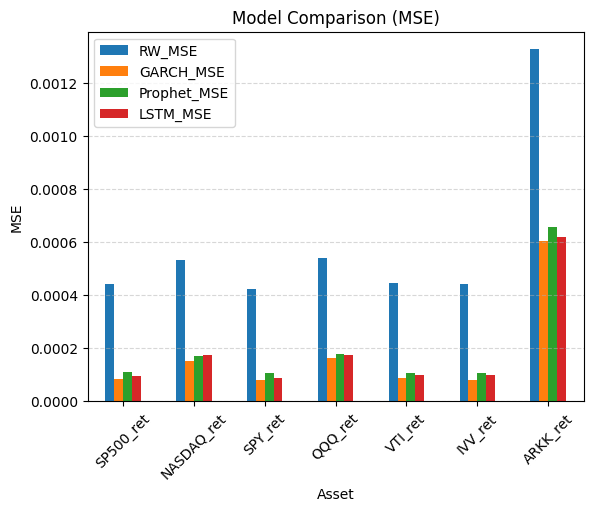

In [15]:
import matplotlib.pyplot as plt

metrics = ["RW_MSE", "GARCH_MSE", "Prophet_MSE", "LSTM_MSE"]

results_plot = results.set_index("Asset")[metrics]

plt.figure(figsize=(12,6))
results_plot.plot(kind="bar")
plt.title("Model Comparison (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


<Figure size 1200x600 with 0 Axes>

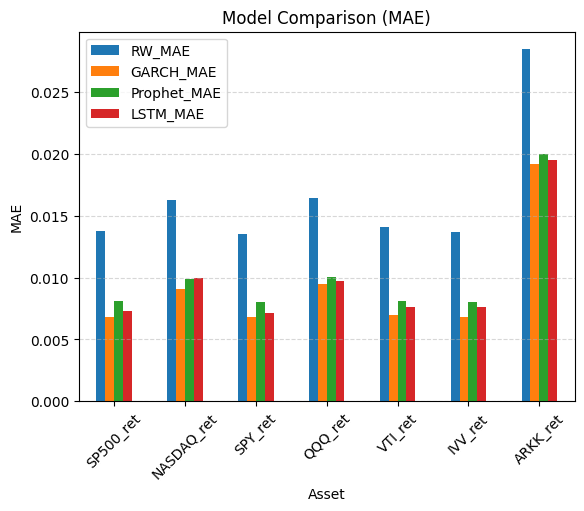

In [16]:
metrics = ["RW_MAE", "GARCH_MAE", "Prophet_MAE", "LSTM_MAE"]

results_plot = results.set_index("Asset")[metrics]

plt.figure(figsize=(12,6))
results_plot.plot(kind="bar")
plt.title("Model Comparison (MAE)")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()
